# Loading_EWAS_Aging_whole_blood_imputated_PLS
DC

## Conclusions

* Partial least squares regression
* Crossvalidation says after 10 PCs more not much benfit
* Fit to full dataset, predictions not as good as simple least squares
* Choosing cpgs by load scores not effective


## DECLARING FUNCTIONS AND LOADING DATA

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
plt.rcdefaults()

In [24]:
import csv
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

In [25]:
import os
# Get
os.getcwd()
# Change
os.chdir('/Users/dcox/EWAS age premade')

In [26]:
tissue_of_interest = 'whole blood'

In [28]:
def test_model_on_heldout_data(X_saved, y_saved, model, mtype='Linear Regression', figsize=(8,4), xlim=None):
    
    # Using  model to make predictions on saved data
    preds_on_saved = model.predict(X_saved)
    MSE_test = mean_squared_error(y_saved, preds_on_saved)
    rms_test = (mean_squared_error(y_saved, preds_on_saved))**0.5
    r2_test = r2_score(y_saved, preds_on_saved)
    MAE_test = mean_absolute_error(y_saved, preds_on_saved)
    r_test_corr = np.corrcoef(y_saved, preds_on_saved)[0,1] # preds_on_saved
    
    # Plotting results
    model_type = mtype

    fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.scatter(y_saved, preds_on_saved, alpha=0.5)
    ax.plot(range(20,100), range(20,100), c='red')
    ax.set_xlabel('True Age')
    if xlim !=None:
        ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylabel('Predicted Age')
    ax.grid(True, lw=1.5, ls='--', alpha=0.75)
    ax.set_title(f'{model_type} on Held Out Data')
    plt.show()

    # print metric
    print(f'The MSE on the saved data is {MSE_test:.3f} years')
    print(f'The rms on the saved data is {rms_test:.3f} years')
    print(f'The r^2 on the saved data is {r2_test:.3f}')
    print(f'The mae on the saved data is {MAE_test:.3f} years')
    print(f'The correlation on the held out data true-predicted is {r_test_corr:.3f}')
    
    return preds_on_saved, MSE_test, rms_test, r2_test, MAE_test, r_test_corr

In [29]:
# Run Linear Regression model and plot and print results
from sklearn.linear_model import LinearRegression
def linear_regress(X_train, y_train, X_test, y_test, plot=True):
    
    #Build fit model
    mod = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs='None')
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    # Plot progress over epochs and final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(16,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Linear Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Linear Regression')
        ax[1].set_xlim(10, 110)
        ax[1].set_ylim(10, 110)
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAe on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f}')
    
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [30]:
# Function for running XGboost regression and print results
from xgboost import XGBRegressor
def xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=None, plot=True):
    
    #Build fit model
    XG = XGBRegressor(objective='reg:squarederror',
                    n_estimators=200,
                    min_child_weight=1,
                    max_depth=3,
                    subsample=0.7,
                    colsample_bytree=0.5,
                    learning_rate=0.1)
    
    eval_set = [(X_train, y_train),(X_test, y_test)]
    XG.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds = early_stopping_rounds, eval_set=eval_set, verbose=False)
    
    
    # Make predictions and evaluate
    preds_train = XG.predict(X_train)
    preds_test = XG.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    results = XG.evals_result()
    epochs = len(results['validation_0']['rmse'])
    
    # Plot progress over epochs and final true vs predicted age
    if plot:
#         fig, ax = plt.subplots(1,3, figsize=(16,3.5))
#         ax[0].scatter(y_train, preds_train, alpha=0.5)
#         ax[0].plot(range(20,100), range(20,100), c='red')
#         ax[0].set_xlabel('True Age')
#         ax[0].set_ylabel('Predicted Age')
#         ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
#         ax[0].set_title('XGboost on training data')

#         ax[1].scatter(y_test, preds_test, alpha=0.5)
#         ax[1].plot(range(20,100), range(20,100), c='red')
#         ax[1].set_xlabel('True Age')
#         ax[1].set_ylabel('Predicted Age')
#         ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
#         ax[1].set_title('XGboost')

#         x_axis = range(0, epochs)
#         ax[2].plot(x_axis, results['validation_0']['rmse'], label='Train')
#         ax[2].plot(x_axis, results['validation_1']['rmse'], label='Test')
#         ax[2].legend()
#         ax[2].set_ylabel('rms')
#         ax[2].set_xlabel('epoch')
#         ax[2].set_title('XGBoost rms')
#         plt.show()
        
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('XGboost on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('XGboost')
        ax[1].set_xlim(10, 110)
        ax[1].set_ylim(10, 110)

        plt.show()
    
    # print metric
    print(f'The number of training epochs was {epochs}')
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAE on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f} years')
    
    
    return preds_train, preds_test, XG, rms_train, rms_test, r2_train, r2_test, XG.feature_importances_

In [31]:
# Function for running a ridge Regression model with CV on alpha
# and plot and print results
from sklearn.linear_model import RidgeCV
def ridgeCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5):

    #Build fit model
    mod = mod = RidgeCV(alphas=alphas,cv=cv)
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    # Plot final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Ridge Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Ridge Regression')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAE on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f} years')
    print(f'Optimal alpha from CV = {mod.alpha_}')
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [32]:
# Function for running a lasso Regression model with CV on alpha
# and plot and print results
from sklearn.linear_model import LassoCV
def lassoCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5):

    #Build fit model
    mod = mod = LassoCV(alphas=alphas,cv=cv)
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    # Plot final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Lasso Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Lasso Regression')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAE on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f} years')
    print(f'Optimal alpha from CV = {mod.alpha_}')
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [33]:
# repeat_XGBoost numtrials times using a different split each time 
# returns importance scores for each run in a df 
def repeat_XGBoost(df_processed, numtrials, early_stopping_rounds = 10, test_size=0.20):
    X = df_processed.iloc[:,5:]
    y = df_processed.age
    importances = []
    rms_train = []
    rms_test = []
    r2_train = []
    r2_test = []
    for i in range(numtrials): 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        
        XG = XGBRegressor(objective='reg:squarederror',
                    n_estimators=200,
                    min_child_weight=1,
                    max_depth=3,
                    subsample=0.7,
                    colsample_bytree=0.5,
                    learning_rate=0.1)
    
        eval_set = [(X_train, y_train),(X_test, y_test)]
        XG.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds = early_stopping_rounds, eval_set=eval_set, verbose=False)
        
        preds_train = XG.predict(X_train)
        preds_test = XG.predict(X_test)
        rms_train.append((mean_squared_error(y_train, preds_train))**0.5)
        rms_test.append((mean_squared_error(y_test, preds_test))**0.5)
        r2_train.append(r2_score(y_train, preds_train))
        r2_test.append(r2_score(y_test, preds_test))
        print(i+1, f'r^2 test = {r2_score(y_test, preds_test)}')
        importances.append(XG.feature_importances_)
    df_imp = pd.DataFrame(importances, columns = df_processed.columns[5:])
    df_imp = df_imp.transpose()
    cols = []
    for i in range(1,numtrials+1):
        cols.append('trial_'+str(i))
    df_imp.columns = cols
    df_imp['Mean'] = df_imp.mean(axis=1)
    df_imp['Std'] = df_imp.std(axis=1)
    return df_imp, rms_train, rms_test, r2_train, r2_test

# Takes df of importance scores produced by repeat_XGBoost and sorts by mean imp score
def importances_sorted_by_mean(df_imp):
    df_imp_sorted = df_imp.sort_values('Mean', ascending=False)
    return df_imp_sorted

# Makes a histogram of the frequecy of cgs in the top (top_num) importance scores
def histogram_of_top_CpGs_by_importance(df_imp, top_num=20):
    vs = []
    inds = []
    for col in df_imp.columns[:-2]:
        c = df_imp[col].sort_values(ascending=False)
        vs.append(c[:top_num])
        inds  = inds + list(c.index[:top_num])
    h = pd.Series(inds).value_counts()
    # Plotting the first 100 importance scores
    plt.figure(figsize = (30, 12))
    plt.bar(h.index[:100],h[:100])
    plt.title('Frequency of CpGs in the top 100 importances')
    plt.ylabel('Frequency')
    plt.xlabel('CpG')
    plt.xticks(fontsize = 16, rotation=90)
    plt.show()
    return inds, vs, h

In [114]:
# Function for running Partial least Squares regression
from sklearn.cross_decomposition import PLSRegression

def PLS1_regress(X_train, y_train, X_test, y_test, num_components = 10, plot=True, max_iter=500):
    
    #Build fit model
    
    # PLS regression
    pls1 = PLSRegression(n_components=num_components)
    pls1.fit(X_train, y_train)
    
    
    # Make predictions and evaluate
    preds_train = pls1.predict(X_train)
    preds_test = pls1.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    # Plot progress over epochs and final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Partial least square regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Partial least squares on testing data')

    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAe on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f}')
    
    
    return pls1, rms_train, rms_test, r2_train, r2_test

In [111]:
import math
import csv
import re

def findElements(lst1, lst2):
    '''
    returns a list of those elements in list1 that are at the position indices given in list2
    '''
    return [lst1[i] for i in lst2] 

def read_write_age_data_by_tissue(file_in, file_out, search_term, num_rows='all'):
    '''
    Built to operate on the EWAS aging dataset text file named 'age_methylation_v1.txt'
    
    Takes an input csv file, a file name to write to, and a search term which should equal a type of tissue 
    in the tissue row of the data (3rd row).
    
    Writes to a csv file the input data but containingg only the columns with tissue containing any where in it
    the search term
    
    params: 
        file_in (string) (file.csv) path to some existing csv file to read
        file_out (string) name of csv file to write 
        search_term (string) term to search for in tissue row
        
    returns:
        None
    '''
    with open(file_in, 'r') as file_in:

        csv_in = csv.reader(file_in,delimiter= '\t')

        header = next(csv_in)
        age = next(csv_in)
        tissue = next(csv_in)
       
        indices = [0]
        for i, element in enumerate(tissue):
            if re.search(search_term, element):
                indices.append(i)
            
        if len(indices) == 0:
            print('Tissue not found')
            return None 
        
        with open(file_out, 'w') as f_out:
            line_list = []
            csv_out = csv.writer(f_out)

            new_header =  findElements(header, indices)
            new_age =  findElements(age, indices)
            new_tissue =  findElements(tissue, indices)

            csv_out.writerow(new_header)
            #csv_out.writerow(new_age)
            #csv_out.writerow(new_tissue)

            count = 0
            if num_rows=='all':
                for line in csv_in:
                    save = findElements(line, indices)
                    csv_out.writerow(save)
                    count +=1
                    if count%10000 == 0:
                        print(f'finished line {count}')
            else:
                for line in csv_in:
                    if count >= num_rows:
                        break
                    else:
                        save = findElements(line, indices)
                        csv_out.writerow(save)
                        count +=1
                        if count%10000 == 0:
                            print(f'finished line {count}')
        return new_header, new_age, new_tissue

        print(f'\n{count} lines sent to file {file_out} with the tissue field containing {search_term}')
        
        

def read_csv(file, num_rows='all'):
    '''
    
    '''
    with open(file, 'r') as file_in:

        csv_in = csv.reader(file_in,delimiter= ',')

        header = next(csv_in)
        
        with open(file_out, 'w') as f_out:
            
            count=0
            line_list = []
            for line in csv_in:
                line_list.append(line)
            
                if num_rows=='all':
                    for line in csv_in:
                        line_list.append(line)
                        count +=1
                        if count%10000 == 0:
                            print(f'finished line {count}')
                else:
                    for line in csv_in:
                        if count >= num_rows:
                            break
                        else:
                            line_list.append(line)
                            count +=1
                            if count%10000 == 0:
                                print(f'finished line {count}')
        return header,  line_list

        print(f'\n{count} lines stored in line_list')

In [35]:
'./age_methylation_v1/'+ tissue_of_interest + '_age_methylation_v1.txt'

'./age_methylation_v1/whole blood_age_methylation_v1.txt'

In [36]:
%%time
# Writing data to a file with the above function selecting out a certain tissue
file_out = './age_methylation_v1/'+ tissue_of_interest + '_age_methylation_v1.txt'
new_header, new_age, new_tissue = read_write_age_data_by_tissue('./age_methylation_v1/age_methylation_v1.txt', file_out, tissue_of_interest, num_rows='all')

finished line 10000
finished line 20000
finished line 30000
finished line 40000
finished line 50000
finished line 60000
finished line 70000
finished line 80000
finished line 90000
finished line 100000
finished line 110000
finished line 120000
finished line 130000
finished line 140000
finished line 150000
finished line 160000
finished line 170000
finished line 180000
finished line 190000
finished line 200000
finished line 210000
finished line 220000
finished line 230000
finished line 240000
finished line 250000
finished line 260000
finished line 270000
finished line 280000
finished line 290000
finished line 300000
finished line 310000
finished line 320000
finished line 330000
finished line 340000
finished line 350000
finished line 360000
finished line 370000
finished line 380000
finished line 390000
finished line 400000
finished line 410000
finished line 420000
finished line 430000
finished line 440000
finished line 450000
finished line 460000
finished line 470000
finished line 480000
C

In [40]:
%%time
# Reading data back in in chunks
import warnings
warnings.simplefilter(action='ignore', category=Warning)

chunksize = 10000
dfs = []
df_chunk = pd.read_csv(file_out, header=0, chunksize=chunksize)
for chunk in df_chunk:
    dfs.append(chunk)

CPU times: user 1min 13s, sys: 2.7 s, total: 1min 15s
Wall time: 1min 16s


In [41]:
%%time
# Combining chunks into 1 dataframe
df = pd.concat(dfs).set_index('sample_id') 

CPU times: user 4.18 s, sys: 8.49 s, total: 12.7 s
Wall time: 17.5 s


In [42]:
%%time
# transposing dataframe
df_t = df.transpose()

CPU times: user 6.03 ms, sys: 119 ms, total: 125 ms
Wall time: 147 ms


In [43]:
# Inserting columns for tissue and age and setting age dtype to float and then rounding to int
df_t.insert(0, 'age', new_age[1:])
df_t.insert(0, 'tissue', new_tissue[1:])
df_t.age = df_t.age.astype('float')
df_t.age = df_t.age.apply(np.rint)
df_t.age = df_t.age.astype('int64')

In [44]:
df_t.shape

(1802, 485514)

In [46]:
# remove columns with more than 25% NAs
df_processed_imp = df_t.dropna(thresh = 0.75*df_t.shape[0], axis=1)

In [47]:
df_processed_imp.shape

(1802, 406628)

In [48]:
%%time
# Impute all values with column mean
df_processed_imp = df_processed_imp.fillna(df_processed_imp.mean())

CPU times: user 6min 2s, sys: 4min 48s, total: 10min 51s
Wall time: 15min 36s


In [50]:
# Selecting out samples with age > 20
df_processed_imp_over20 = df_processed_imp[df_processed_imp.age >=20]

#### Dividing data into working and saved parts (75/25 split)

In [52]:
df_processed_imp_over20.shape

(1422, 406628)

In [53]:
# Splitting data into Working and Saved by random selection of rows

import random

num_samples = df_processed_imp_over20.shape[0]
num_for_saving = int(round(df_processed_imp_over20.shape[0]*.25))

np.random.seed(2021)

saved_index = np.random.choice(np.arange(num_samples), size=num_for_saving, replace=False)
keep_index = []
for num in range(num_samples):
    if num not in saved_index:
        keep_index.append(num)

df_p_saved = df_processed_imp_over20.iloc[saved_index, :]
df_p_working = df_processed_imp_over20.iloc[keep_index, :]

## HERE STARTS THE PLS ANALYSIS

In [182]:
# Make train test split of working data
from sklearn.model_selection import train_test_split
X = df_p_working.iloc[:,2:]
y = df_p_working.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2021)

In [183]:
plt.rcdefaults()

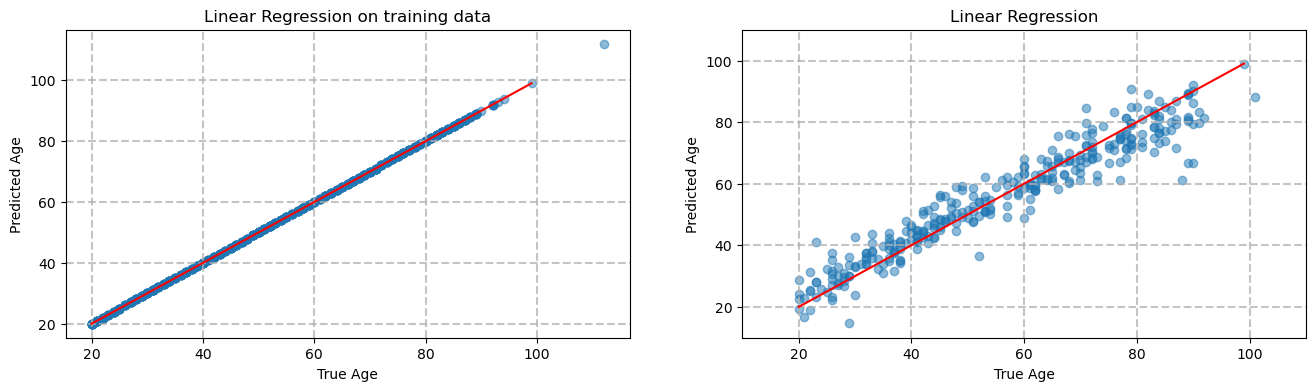

The rms on the training data is 0.000 years
The rms on the testing data is 6.366 years
The r^2 on the training data is 1.000
The r^2 on the testing data is 0.904
The MAe on the training data is 0.000 years
The MAE on the testing data is 4.625


In [184]:
# Linear regression full data
mod, rms_train, rms_test, r2_train, r2_test = linear_regress(X_train, y_train, X_test, y_test, plot=True)

The rms on the training data is 0.088 years
The rms on the testing data is 6.746 years
The r^2 on the training data is 1.000
The r^2 on the testing data is 0.893
The MAe on the training data is 0.048 years
The MAE on the testing data is 4.913
CPU times: user 2min 3s, sys: 12.7 s, total: 2min 15s
Wall time: 1min 27s


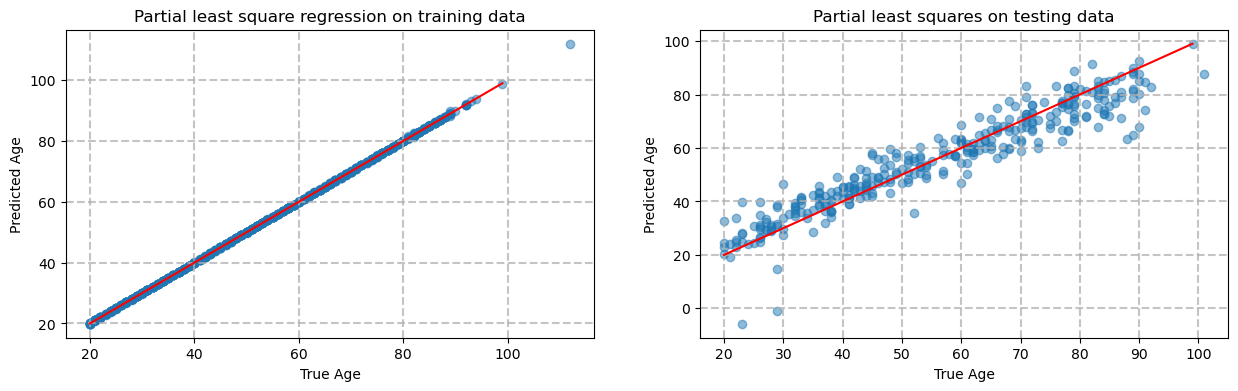

In [169]:
%%time
# pls1 regression with 20 components
pls1, rms_train, rms_test, r2_train, r2_test = PLS1_regress(X_train, y_train, X_test, y_test, num_components = 20, plot=True, max_iter=500)

The rms on the training data is 1.881 years
The rms on the testing data is 6.901 years
The r^2 on the training data is 0.992
The r^2 on the testing data is 0.888
The MAe on the training data is 1.381 years
The MAE on the testing data is 5.041
CPU times: user 1min 7s, sys: 7.45 s, total: 1min 15s
Wall time: 49.9 s


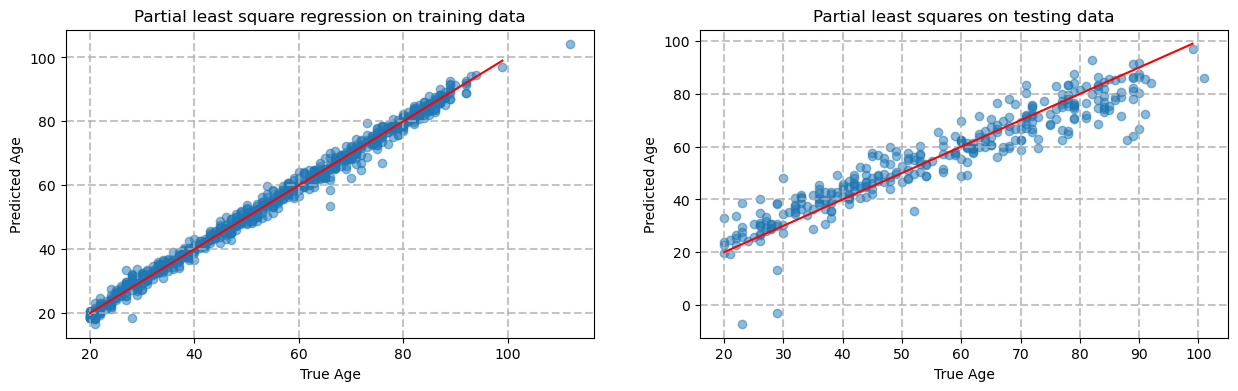

In [170]:
%%time
pls1, rms_train, rms_test, r2_train, r2_test = PLS1_regress(X_train, y_train, X_test, y_test, num_components = 10, plot=True, max_iter=500)

### Can we use to select features? 

In [171]:
# take 100 cpgs with largest mean loadings over 10 components
mean_loadings = pls1.x_loadings_.mean(axis=1)

In [172]:
# take 100 cpgs with largest loadings from 1st component
f_loadings = pls1.x_loadings_[:, 0]

In [173]:
# Makingdataframes with cpgs, mean_loadings, and first_loadings sorted by mean loadings or first loadings
cpgs = X.columns
df_cpg_loadings = pd.DataFrame({'cpg':cpgs,'mean_loading':mean_loadings, 'first_loadings':f_loadings })
df_cpg_loadings_sorted_mean = df_cpg_loadings.sort_values('mean_loading', ascending=False)
df_cpg_loadings_sorted_first = df_cpg_loadings.sort_values('first_loadings', ascending=False)


In [174]:
# get top 100 cpgs for each case
top_100_cpg_by_mean_loadings = df_cpg_loadings_sorted_mean.cpg[:100].values
top_100_cpg_by_first_loadings = df_cpg_loadings_sorted_first.cpg[:100].values

### Now fitting with top100 cpgs by mean loadings

In [175]:
df_p_working_100 = df_p_working[top_100_cpg_by_mean_loadings]
X = df_p_working_100 
y = df_p_working.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2021)

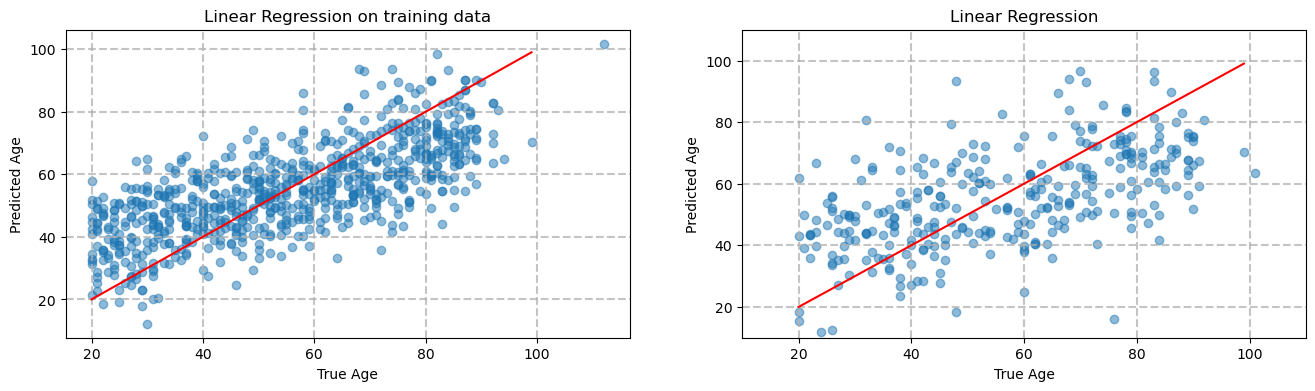

The rms on the training data is 14.419 years
The rms on the testing data is 17.644 years
The r^2 on the training data is 0.506
The r^2 on the testing data is 0.265
The MAe on the training data is 11.768 years
The MAE on the testing data is 14.495


In [176]:
# Linear regression
mod, rms_train, rms_test, r2_train, r2_test = linear_regress(X_train, y_train, X_test, y_test, plot=True)

### Now fitting with top100 cpgs by first component's  loadings

In [177]:
df_p_working_100 = df_p_working[top_100_cpg_by_first_loadings]
X = df_p_working_100 
y = df_p_working.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2021)

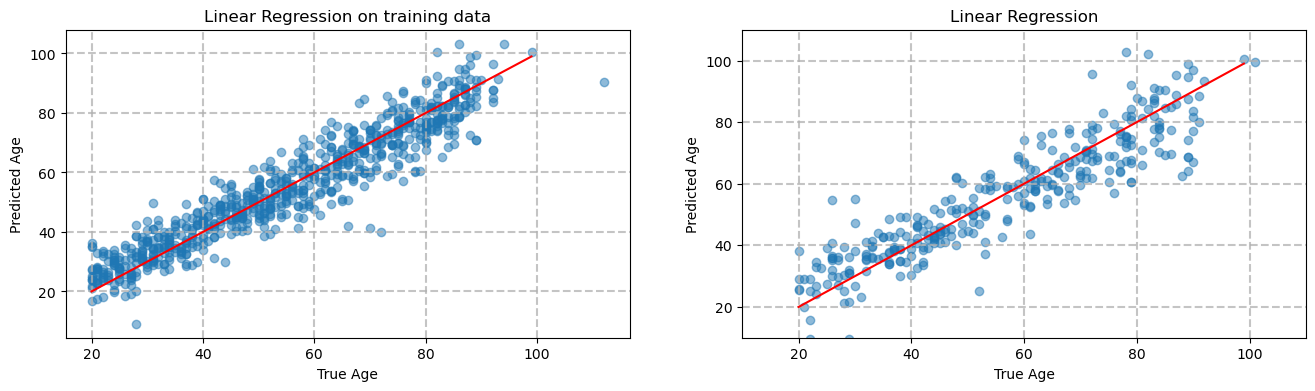

The rms on the training data is 6.673 years
The rms on the testing data is 8.684 years
The r^2 on the training data is 0.894
The r^2 on the testing data is 0.822
The MAe on the training data is 5.148 years
The MAE on the testing data is 6.588


In [178]:
# Linear regression
mod, rms_train, rms_test, r2_train, r2_test = linear_regress(X_train, y_train, X_test, y_test, plot=True)

### Crossvalidation to determine optimumn number of PLS components

In [179]:
# Make train test split of working data
from sklearn.model_selection import train_test_split
X = df_p_working.iloc[:,2:]
y = df_p_working.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2021)

In [180]:
%%time
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score
scores = []
for num in [1, 10, 20, 50]:
    model = PLSRegression(n_components=num)
    five_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    mean_score = np.array(five_scores).mean()
    std_score = np.array(five_scores).std()
    scores.append(mean_score)
    print(f'{num} , {mean_score:.4f} ± {std_score:.4f}')

1 , -291.2177 ± 186.7464
10 , -51.8152 ± 22.9062
20 , -50.3786 ± 22.3722
50 , -50.2883 ± 22.3533
CPU times: user 48min 39s, sys: 5min 1s, total: 53min 40s
Wall time: 1h 49min 28s


In [181]:
### Now compare to linear regression with top100 byu XGboost

In [ ]:
import pickle
with open('cpgs_XGboost_whole_blood_ranked', 'rb') as fp:
    cpgs_XGboost_whole_blood_ranked = pickle.load(fp)
Top100_cpgs_XGboost = cpgs_XGboost_whole_blood_ranked[:100]

In [102]:
from sklearn.model_selection import train_test_split
X = df_p_working[Top100_cpgs_XGboost]
y = df_p_working.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2021)

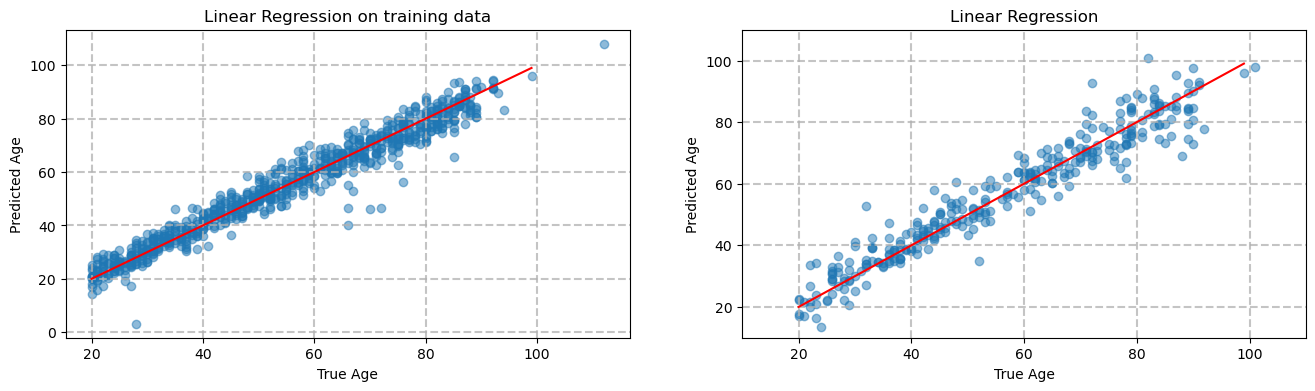

The rms on the training data is 4.459 years
The rms on the testing data is 5.797 years
The r^2 on the training data is 0.953
The r^2 on the testing data is 0.921
The MAe on the training data is 3.261 years
The MAE on the testing data is 4.243


In [103]:
plt.rcdefaults()
mod_100, rms_train, rms_test, r2_train, r2_test = linear_regress(X_train, y_train, X_test, y_test, plot=True)

### How many top100 cpgs from first loadings in Top 100 by XGboost

In [ ]:
count=0
for i, cpg in enumerate(top_100_cpg_by_first_loadings):
    if cpg in Top100_cpgs_XGboost:
        print(i, cpg)
        count+=1
print(count)